<a href="https://colab.research.google.com/github/vshalisko/GEE/blob/main/Colab/ESE_dos_Landsat_ANN_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Uso de ANN para clasificacion de Landsat 8 y 5
* Se usa Keras 2.13 y tensorflow 2.13, para esto se desinstala la actual version 3 - por corregir
* Versión con la estandarizaciíón de datos con StandardScaler
* Clasificación en tres clases (no-urbano, urbano, agua)
* Dos modelos L8 y L5

In [1]:
!pip uninstall tensorflow
!pip3 install tensorflow==2.13

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 22.6 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing

In [1]:
!pip install pyrsgis
from pyrsgis import raster, convert

Preparar el entorno

In [2]:
import random
import math, glob, time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, cohen_kappa_score
from google.colab import drive

random.seed(2)

Coneccion con Google Drive para almacenar archivos

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


Lectura de datos en formato numpy

In [4]:
# Load the arrays as .npy files
array_feature_2015 = np.load('/content/drive/MyDrive/Colab Data/ESE_2015_feature_L8_6b.npy')
array_feature_2014 = np.load('/content/drive/MyDrive/Colab Data/ESE_2014_feature_L8_6b.npy')
array_feature_2020 = np.load('/content/drive/MyDrive/Colab Data/ESE_2020_feature_L8_6b.npy')

array_feature_2011 = np.load('/content/drive/MyDrive/Colab Data/ESE_2011_feature_L5_6b.npy')
array_feature_2010 = np.load('/content/drive/MyDrive/Colab Data/ESE_2010_feature_L5_6b.npy')
array_feature_2000 = np.load('/content/drive/MyDrive/Colab Data/ESE_2000_feature_L5_6b.npy')

array_target_binary_2015 = np.load('/content/drive/MyDrive/Colab Data/ESE_2015_target_2class.npy')
array_target_2015 = np.load('/content/drive/MyDrive/Colab Data/ESE_2015_target_3class.npy')

Transformar datos para trabajo con ANN en Keras - Tensor Flow

In [5]:
def feature_transform(source_array):
    array_t = np.transpose(source_array, (2, 0, 1))
    print(array_t.shape)
    table_array = convert.array_to_table(array_t)
    print(table_array.shape)
    return table_array

In [6]:
x_features_2020 = feature_transform(array_feature_2020)
x_features_2015 = feature_transform(array_feature_2015)
x_features_2014 = feature_transform(array_feature_2014)
x_features_2011 = feature_transform(array_feature_2011)
x_features_2010 = feature_transform(array_feature_2010)
x_features_2000 = feature_transform(array_feature_2000)
y_labels_2015 = feature_transform(array_target_2015)
y_labels_binary_2015 = feature_transform(array_target_binary_2015)

## codigo innecesario cuando se aplica estandarizacion StandardScaler
#y_labels_2015 = y_labels_2015 - 1
#x_features_2014 = x_features_2014 / 32768
#x_features_2015 = x_features_2015 / 32768
#x_features_2020 = x_features_2020 / 32768
nBands = x_features_2015.shape[1]

(6, 652, 468)
(305136, 6)
(6, 652, 468)
(305136, 6)
(6, 652, 468)
(305136, 6)
(6, 652, 468)
(305136, 6)
(6, 652, 468)
(305136, 6)
(6, 652, 468)
(305136, 6)
(1, 652, 468)
(305136, 1)
(1, 652, 468)
(305136, 1)


Estandarización de datos

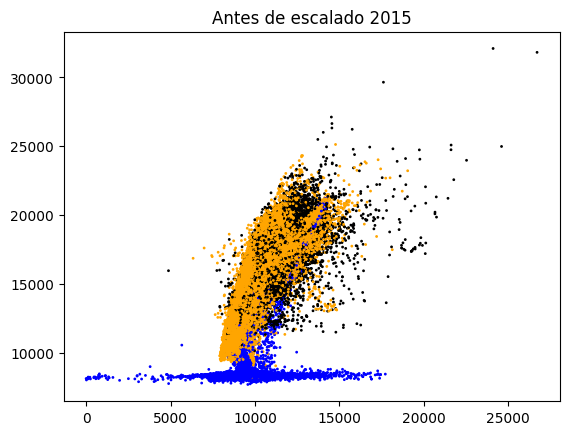

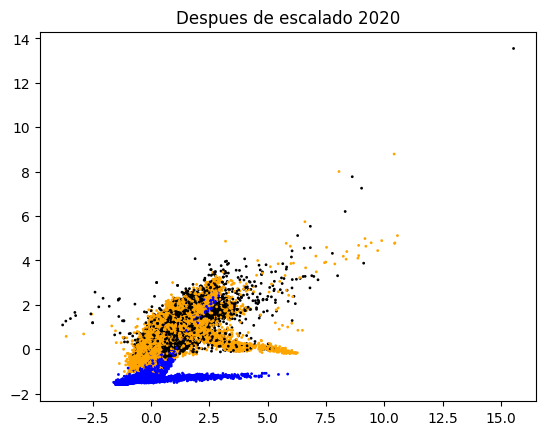

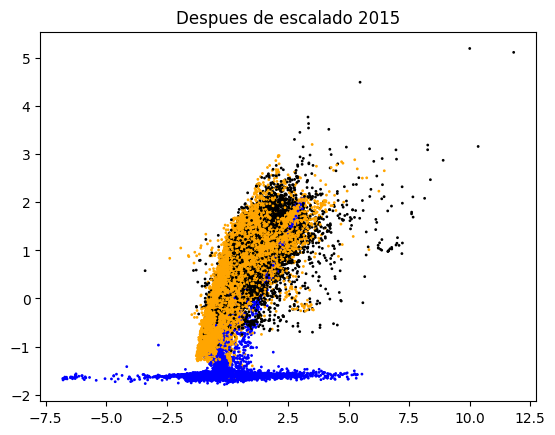

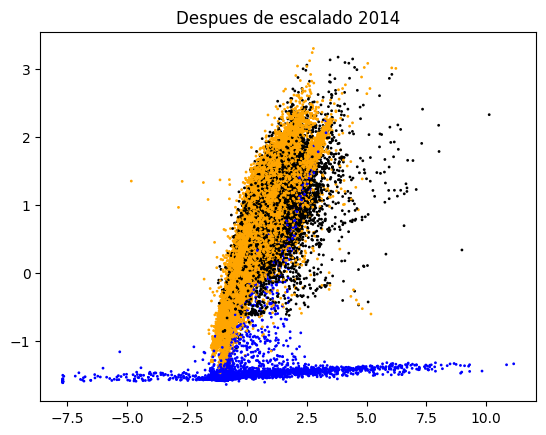

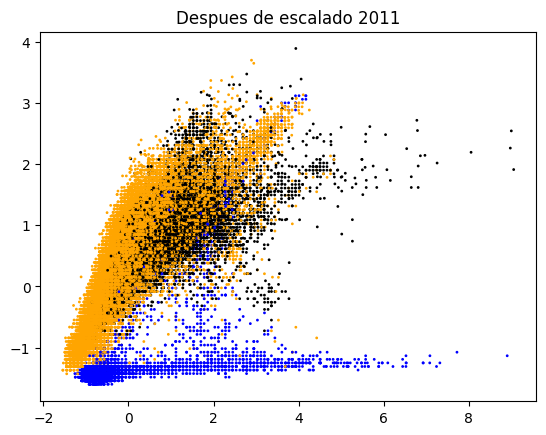

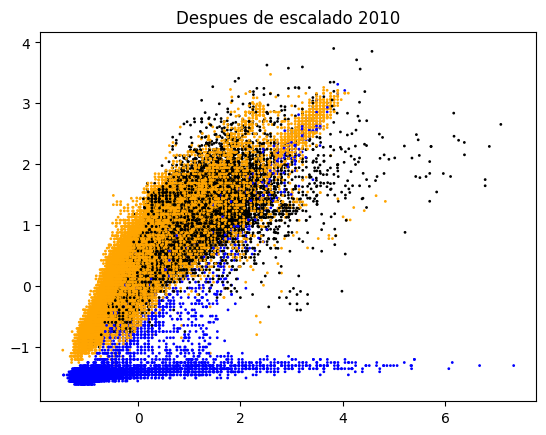

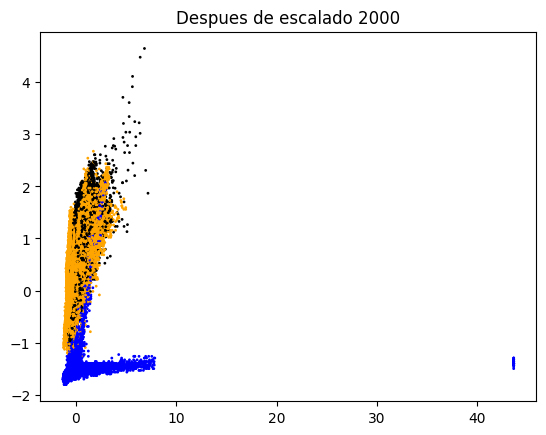

In [8]:
## visualización de la muestre de 50 k elementos
colors = ['orange', 'blue', 'black']
rango = slice(200000,400000)
colors_list = [colors[int(i) % 3] for i in y_labels_2015[rango,0]]

plt.scatter(x_features_2015[rango,0], x_features_2015[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Antes de escalado 2015')
plt.show()

scale = StandardScaler()
x_features_2020 = scale.fit_transform(x_features_2020)
x_features_2014 = scale.fit_transform(x_features_2014)
x_features_2015 = scale.fit_transform(x_features_2015)
x_features_2011 = scale.fit_transform(x_features_2011)
x_features_2010 = scale.fit_transform(x_features_2010)
x_features_2000 = scale.fit_transform(x_features_2000)

plt.scatter(x_features_2020[rango,0], x_features_2020[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2020')
plt.show()

plt.scatter(x_features_2015[rango,0], x_features_2015[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2015')
plt.show()

plt.scatter(x_features_2014[rango,0], x_features_2014[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2014')
plt.show()

plt.scatter(x_features_2011[rango,0], x_features_2011[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2011')
plt.show()

plt.scatter(x_features_2010[rango,0], x_features_2010[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2010')
plt.show()

plt.scatter(x_features_2000[rango,0], x_features_2000[rango,5], marker='o',
            color=colors_list, s=1)
plt.title('Despues de escalado 2000')
plt.show()

In [9]:
print(x_features_2015)
print(y_labels_2015)

[[-6.54360118e-01 -5.58794604e-01 -3.94408852e-01  3.73691067e-02
  -2.32251301e-01 -3.38724141e-01]
 [-9.02329108e-01 -7.23705027e-01 -6.57926965e-01  3.59745555e-01
  -2.92506245e-01 -5.05108569e-01]
 [-9.86610703e-01 -6.67687836e-01 -6.83731409e-01  7.05232474e-01
  -1.10991352e-01 -4.64798939e-01]
 ...
 [-7.47696760e-01 -7.49881284e-01 -8.19791206e-01  8.01905248e-04
  -2.04499024e-01 -5.24262790e-01]
 [-6.78042550e-01 -7.16375675e-01 -7.47851543e-01 -1.35228084e-01
  -1.54494921e-01 -3.79605538e-01]
 [-6.09084881e-01 -6.37846902e-01 -6.07100029e-01 -2.67162547e-01
  -2.84845827e-02 -1.26598290e-01]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


Subdividir datos de entrenamiento y control (2015)

In [10]:
xTrain, xTest, yTrain, yTest = train_test_split(x_features_2015, y_labels_2015, test_size=0.4, random_state=242)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

print(xTrain)
print(yTrain)

# Reshape the data
xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))

print(xTrain.shape, xTest.shape)

(183081, 6)
(183081, 1)
(122055, 6)
(122055, 1)
[[-0.13404316  0.02807709  0.02667276  1.37719137  0.41205156  0.05779682]
 [ 1.11485683  1.47091241  1.32901524  0.75876686  0.78333202  0.97348294]
 [ 1.55785761  1.68555772  1.74618709  1.11185975  1.01410096  1.16388162]
 ...
 [-0.51853441 -0.56926511 -0.50583713 -0.09749073  0.1285283   0.02206134]
 [ 0.90728729  0.73745367  0.66044555  0.73799669  0.17778234  0.09181701]
 [-0.51644478 -0.14678031 -0.0800638   0.82780573  0.65107117  0.35597373]]
[[0]
 [2]
 [2]
 ...
 [0]
 [2]
 [0]]
(183081, 1, 6) (122055, 1, 6)


Entrenar la red neuronal (ANN) simple con 2 capas ocultas

In [11]:
from tensorflow import keras

# Define the parameters of the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(3, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Run the model
model.fit(xTrain, yTrain, epochs=10)

Epoch 1/10
5722/5722 [==============================] - 15s 3ms/step - loss: 0.2404 - accuracy: 0.9038
Epoch 2/10
5722/5722 [==============================] - 10s 2ms/step - loss: 0.2060 - accuracy: 0.9140
Epoch 3/10
5722/5722 [==============================] - 12s 2ms/step - loss: 0.2020 - accuracy: 0.9161
Epoch 4/10
5722/5722 [==============================] - 12s 2ms/step - loss: 0.1996 - accuracy: 0.9174
Epoch 5/10
5722/5722 [==============================] - 11s 2ms/step - loss: 0.1972 - accuracy: 0.9189
Epoch 6/10
5722/5722 [==============================] - 11s 2ms/step - loss: 0.1957 - accuracy: 0.9198
Epoch 7/10
5722/5722 [==============================] - 12s 2ms/step - loss: 0.1944 - accuracy: 0.9206
Epoch 8/10
5722/5722 [==============================] - 12s 2ms/step - loss: 0.1936 - accuracy: 0.9206
Epoch 9/10
5722/5722 [==============================] - 12s 2ms/step - loss: 0.1932 - accuracy: 0.9211
Epoch 10/10
5722/5722 [==============================] - 11s 2ms/step - l

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense (Dense)               (None, 20)                140       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 383 (1.50 KB)
Trainable params: 383 (1.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [12]:
model.save('/content/drive/MyDrive/Colab Data/ESE_2015_model_ANN_2hl_3class.tensorflow')

In [13]:
# Predict for test data
yTestPredicted_raw = model.predict(xTest)
yTestPredicted_class = yTestPredicted_raw.argmax(axis=-1)

3815/3815 [==============================] - 10s 2ms/step


In [14]:
#yTestPredicted = yTestPredicted_raw[:,:]

## Aplicable solo para clasificacion binaria
#roc_auc_raw = roc_auc_score(yTest, yTestPredicted)
#yTestPredicted = (yTestPredicted>0.5).astype(int)
#yTestPredicted = yTestPredicted.argmax(axis=1)
#roc_auc = roc_auc_score(yTest, yTestPredicted)

## Aplicable para clasificacion multiclase
cMatrix = confusion_matrix(yTest, yTestPredicted_class)
accuracy = accuracy_score(yTest, yTestPredicted_class)
kappa = cohen_kappa_score(yTest, yTestPredicted_class)
pScore = precision_score(yTest, yTestPredicted_class, average=None)
rScore = recall_score(yTest, yTestPredicted_class, average=None)
f1Score = f1_score(yTest, yTestPredicted_class, average=None)

print("Confusion matrix:\n", cMatrix)
print("\nExactitud (accuracy): %.3f," % accuracy)
print("\nKappa de Cohen: %.3f," % kappa)
#print("\nROC AUC raw: %.3f," % roc_auc_raw)
#print("\nROC AUC: %.3f," % roc_auc)
print("\nClase 1. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[0], rScore[0], f1Score[0]))
print("\nClase 2. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[1], rScore[1], f1Score[1]))
print("\nClase 3. Selectividad (precision): %.3f, especificidad (recall): %.3f, f1: %.3f" % (pScore[2], rScore[2], f1Score[2]))

Confusion matrix:
 [[64083    67  4217]
 [  185 23144   191]
 [ 4992    95 25081]]

Exactitud (accuracy): 0.920,

Kappa de Cohen: 0.864,

Clase 1. Selectividad (precision): 0.925, especificidad (recall): 0.937, f1: 0.931

Clase 2. Selectividad (precision): 0.993, especificidad (recall): 0.984, f1: 0.989

Clase 3. Selectividad (precision): 0.851, especificidad (recall): 0.831, f1: 0.841


Predicción para datos de 2015

In [15]:
x_features_2015_n = x_features_2015
x_features_2015_n = x_features_2015_n.reshape((x_features_2015_n.shape[0], 1, x_features_2015_n.shape[1]))

predicted_2015 = model.predict(x_features_2015_n)
print(predicted_2015)

9536/9536 [==============================] - 13s 1ms/step
[[9.9688870e-01 5.0489609e-05 3.0608345e-03]
 [9.7681457e-01 2.2562689e-03 2.0929160e-02]
 [9.5462716e-01 8.4374277e-03 3.6935464e-02]
 ...
 [9.9719983e-01 4.1661269e-04 2.3834668e-03]
 [9.9908829e-01 5.3489068e-05 8.5824437e-04]
 [9.9907255e-01 1.0749751e-05 9.1674627e-04]]


Vista de la superficie de 2015 con etiquetas categoricas de mayor probabilidad

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


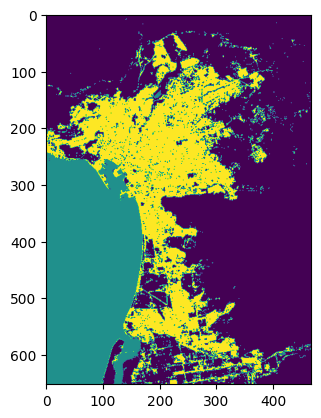

In [16]:
predicted_2015_class = predicted_2015.argmax(axis=-1)
print(predicted_2015_class.reshape(x_features_2015_n.shape[0], 1))
predicted_2015_class_re = np.reshape(predicted_2015_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2015_class_re[:,:])
plt.show()

Superficie de probabilidad para clase urbano en 2015

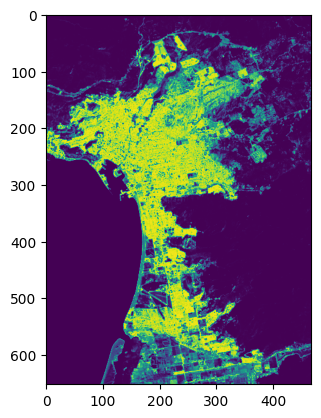

In [17]:
prediction_2015_urbano = np.reshape(predicted_2015[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2015 = (prediction_2015_urbano).astype('float')
plt.imshow(B_img_pred_2015[:,:])
plt.show()

Predicción para 2020

In [18]:
x_features_2020_n = x_features_2020
x_features_2020_n = x_features_2020_n.reshape((x_features_2020_n.shape[0], 1, x_features_2020_n.shape[1]))

predicted_2020 = model.predict(x_features_2020_n)
print(predicted_2020)

9536/9536 [==============================] - 14s 1ms/step
[[8.90826046e-01 2.59716809e-03 1.06576689e-01]
 [8.78840029e-01 6.30254904e-03 1.14857495e-01]
 [9.36567128e-01 2.78408430e-03 6.06487989e-02]
 ...
 [9.59040165e-01 4.50206501e-03 3.64576355e-02]
 [9.76137817e-01 2.46552192e-03 2.13966686e-02]
 [9.93544638e-01 4.30295884e-04 6.02511223e-03]]


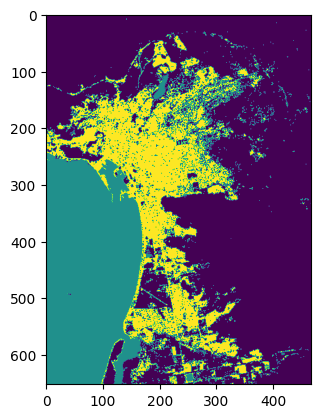

In [19]:
predicted_2020_class = predicted_2020.argmax(axis=-1)
predicted_2020_class_re = np.reshape(predicted_2020_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2020_class_re[:,:])
plt.show()

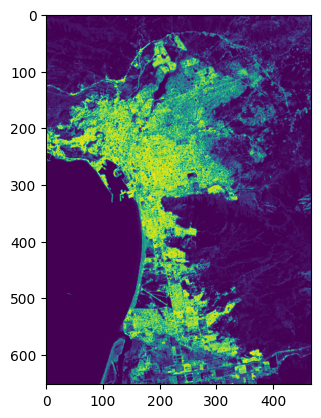

In [20]:
prediction_2020_urbano = np.reshape(predicted_2020[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2020 = (prediction_2020_urbano).astype('float')
plt.imshow(B_img_pred_2020[:,:])
plt.show()


Predicción para 2014

In [21]:
x_features_2014_n = x_features_2014
x_features_2014_n = x_features_2014_n.reshape((x_features_2014_n.shape[0], 1, x_features_2014_n.shape[1]))

predicted_2014 = model.predict(x_features_2014_n)
print(predicted_2014)

9536/9536 [==============================] - 19s 2ms/step
[[9.9519283e-01 9.9203069e-05 4.7079436e-03]
 [9.5160294e-01 4.4167419e-03 4.3980297e-02]
 [9.1336262e-01 1.0756065e-02 7.5881392e-02]
 ...
 [9.9953574e-01 4.5058274e-05 4.1922278e-04]
 [9.9932462e-01 5.6877925e-05 6.1851938e-04]
 [9.9861282e-01 1.6648100e-05 1.3704330e-03]]


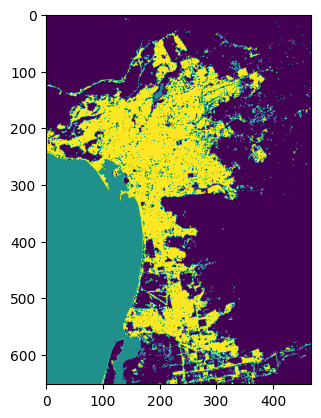

In [22]:
predicted_2014_class = predicted_2014.argmax(axis=-1)
predicted_2014_class_re = np.reshape(predicted_2014_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2014_class_re[:,:])
plt.show()

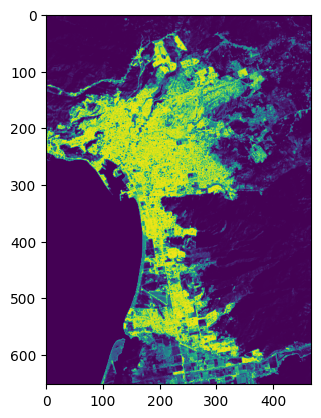

In [23]:
prediction_2014_urbano = np.reshape(predicted_2014[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2014 = (prediction_2014_urbano).astype('float')
plt.imshow(B_img_pred_2014[:,:])
plt.show()

Guardar capas numpy de prediccion

In [24]:
# Save the arrays as .npy files
np.save('/content/drive/MyDrive/Colab Data/ESE_2014_prediction_class.npy', predicted_2014_class)
np.save('/content/drive/MyDrive/Colab Data/ESE_2015_prediction_class.npy', predicted_2015_class)
np.save('/content/drive/MyDrive/Colab Data/ESE_2020_prediction_class.npy', predicted_2020_class)
np.save('/content/drive/MyDrive/Colab Data/ESE_2014_prediction_urbano_float.npy', prediction_2014_urbano)
np.save('/content/drive/MyDrive/Colab Data/ESE_2015_prediction_urbano_float.npy', prediction_2015_urbano)
np.save('/content/drive/MyDrive/Colab Data/ESE_2020_prediction_urbano_float.npy', prediction_2020_urbano)

In [25]:
x_features_2011_n = x_features_2011
x_features_2011_n = x_features_2011_n.reshape((x_features_2011_n.shape[0], 1, x_features_2011_n.shape[1]))

y_target_2011_n = predicted_2015_class.reshape(x_features_2015_n.shape[0], 1)

print(x_features_2011_n.shape, y_target_2011_n.shape)

# Define the parameters of the model
model1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(3, activation='softmax')])

# Define the accuracy metrics and parameters
model1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Run the model
model1.fit(x_features_2011_n, y_target_2011_n, epochs=10)

(305136, 1, 6) (305136, 1)
Epoch 1/10
9536/9536 [==============================] - 20s 2ms/step - loss: 0.1918 - accuracy: 0.9303
Epoch 2/10
9536/9536 [==============================] - 20s 2ms/step - loss: 0.1683 - accuracy: 0.9370
Epoch 3/10
9536/9536 [==============================] - 31s 3ms/step - loss: 0.1655 - accuracy: 0.9374
Epoch 4/10
9536/9536 [==============================] - 20s 2ms/step - loss: 0.1639 - accuracy: 0.9379
Epoch 5/10
9536/9536 [==============================] - 19s 2ms/step - loss: 0.1629 - accuracy: 0.9385
Epoch 6/10
9536/9536 [==============================] - 18s 2ms/step - loss: 0.1622 - accuracy: 0.9385
Epoch 7/10
9536/9536 [==============================] - 19s 2ms/step - loss: 0.1616 - accuracy: 0.9388
Epoch 8/10
9536/9536 [==============================] - 21s 2ms/step - loss: 0.1612 - accuracy: 0.9390
Epoch 9/10
9536/9536 [==============================] - 19s 2ms/step - loss: 0.1608 - accuracy: 0.9391
Epoch 10/10
9536/9536 [=======================

In [26]:
model1.save('/content/drive/MyDrive/Colab Data/ESE_2011_model_ANN_2hl_3class.tensorflow')

In [27]:
x_features_2010_n = x_features_2010
x_features_2010_n = x_features_2010_n.reshape((x_features_2010_n.shape[0], 1, x_features_2010_n.shape[1]))

predicted_2010 = model.predict(x_features_2010_n)
print(predicted_2010)

9536/9536 [==============================] - 21s 2ms/step
[[9.0554088e-01 5.0975843e-03 8.9361593e-02]
 [9.3319750e-01 8.9912629e-03 5.7811283e-02]
 [9.0053636e-01 1.6391158e-02 8.3072312e-02]
 ...
 [9.9972379e-01 3.1886088e-05 2.4431470e-04]
 [9.9947304e-01 3.6295023e-05 4.9054628e-04]
 [9.9961799e-01 1.8121147e-05 3.6396968e-04]]


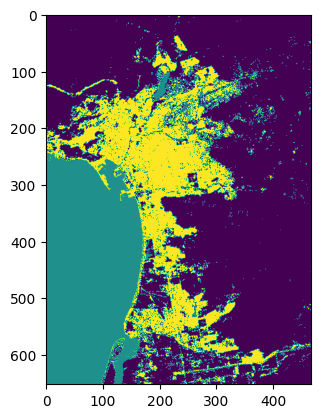

In [28]:
predicted_2010_class = predicted_2010.argmax(axis=-1)
predicted_2010_class_re = np.reshape(predicted_2010_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2010_class_re[:,:])
plt.show()

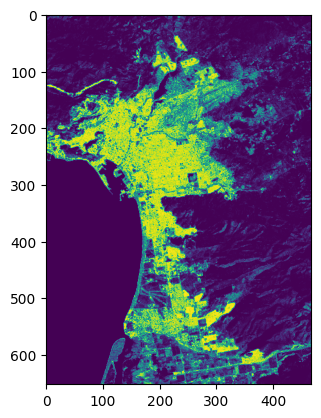

In [29]:
prediction_2010_urbano = np.reshape(predicted_2010[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2010 = (prediction_2010_urbano).astype('float')
plt.imshow(B_img_pred_2010[:,:])
plt.show()

In [30]:
x_features_2000_n = x_features_2000
x_features_2000_n = x_features_2000_n.reshape((x_features_2000_n.shape[0], 1, x_features_2000_n.shape[1]))

predicted_2000 = model.predict(x_features_2000_n)
print(predicted_2000)

9536/9536 [==============================] - 14s 1ms/step
[[9.4968486e-01 2.9699013e-03 4.7345273e-02]
 [9.2912996e-01 4.5798258e-03 6.6290215e-02]
 [9.5930248e-01 2.7086511e-03 3.7988815e-02]
 ...
 [9.9910307e-01 9.1794216e-05 8.0507697e-04]
 [9.9903351e-01 6.1752442e-05 9.0462004e-04]
 [9.9966586e-01 1.5758711e-05 3.1845877e-04]]


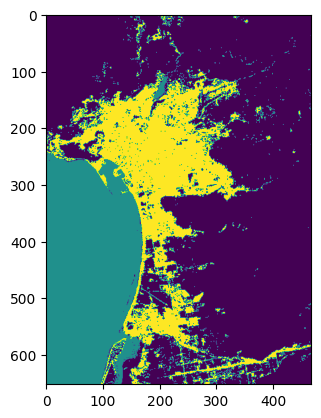

In [31]:
predicted_2000_class = predicted_2000.argmax(axis=-1)
predicted_2000_class_re = np.reshape(predicted_2000_class[:], (array_target_2015.shape[0], array_target_2015.shape[1]))
plt.imshow(predicted_2000_class_re[:,:])
plt.show()

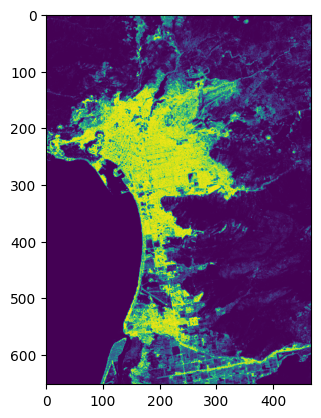

In [32]:
prediction_2000_urbano = np.reshape(predicted_2000[:,2], (array_target_2015.shape[0], array_target_2015.shape[1]))
B_img_pred_2000 = (prediction_2000_urbano).astype('float')
plt.imshow(B_img_pred_2000[:,:])
plt.show()

In [33]:
# Save the arrays as .npy files
np.save('/content/drive/MyDrive/Colab Data/ESE_2010_prediction_class.npy', predicted_2010_class_re)
np.save('/content/drive/MyDrive/Colab Data/ESE_2000_prediction_class.npy', predicted_2000_class_re)
np.save('/content/drive/MyDrive/Colab Data/ESE_2010_prediction_urbano_float.npy', prediction_2010_urbano)
np.save('/content/drive/MyDrive/Colab Data/ESE_2000_prediction_urbano_float.npy', prediction_2000_urbano)